In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


In [3]:
df = pd.read_csv("../dataset/PJME_hourly.csv")
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


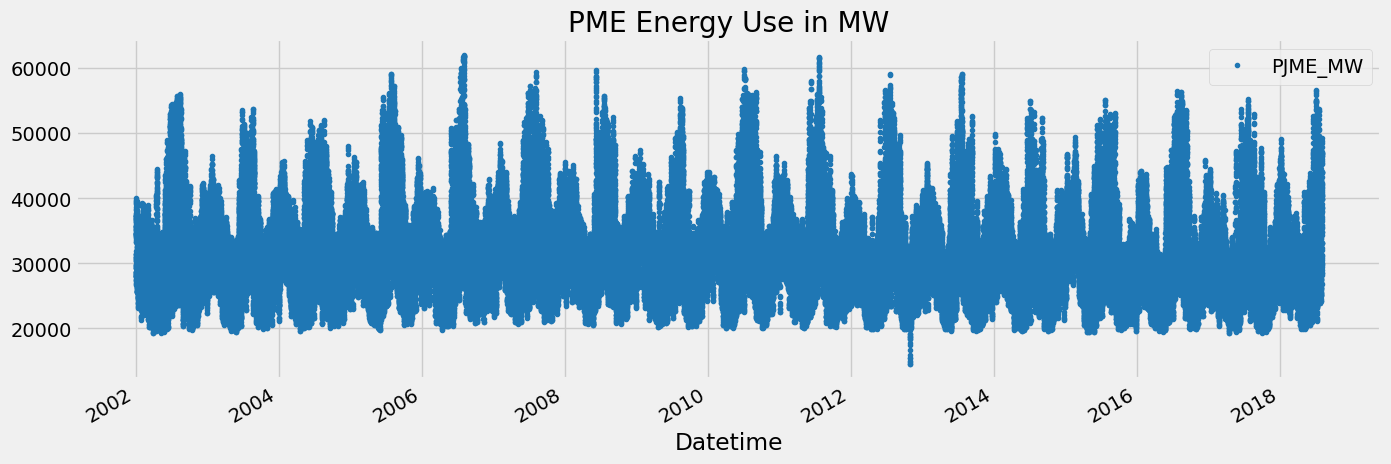

In [4]:
df.plot(style = '.',
        figsize = (15,5),
        color = color_pal[0],
        title = 'PME Energy Use in MW'
)
plt.show()

Train/Test Split

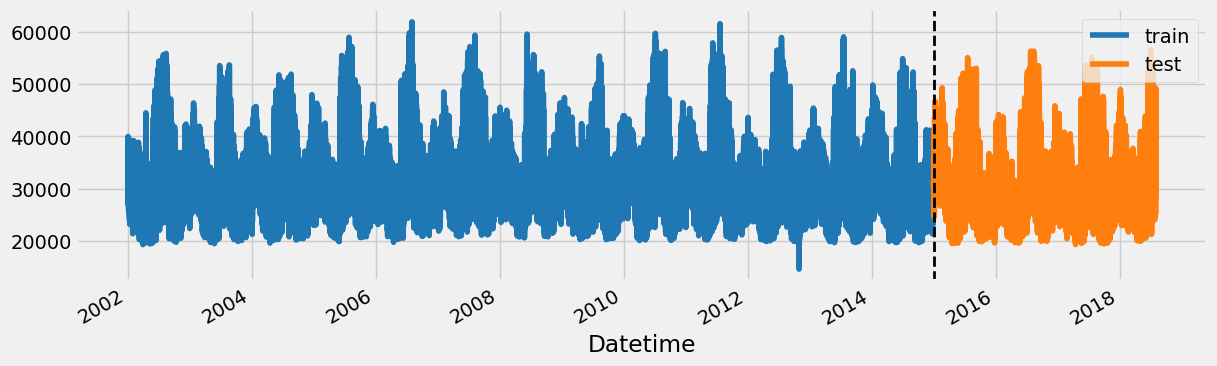

In [5]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(1,1, figsize = (13,4))
train['PJME_MW'].plot(ax=ax, color = color_pal[0])
test['PJME_MW'].plot(ax=ax, color = color_pal[1])
ax.axvline('01-01-2015', color = 'black', linestyle = '--', lw = 2)
ax.legend(['train', 'test'])
plt.show()

Feature Creation

In [6]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df


In [7]:
df = create_features(df)

Visualize our Feature / Target Relationship

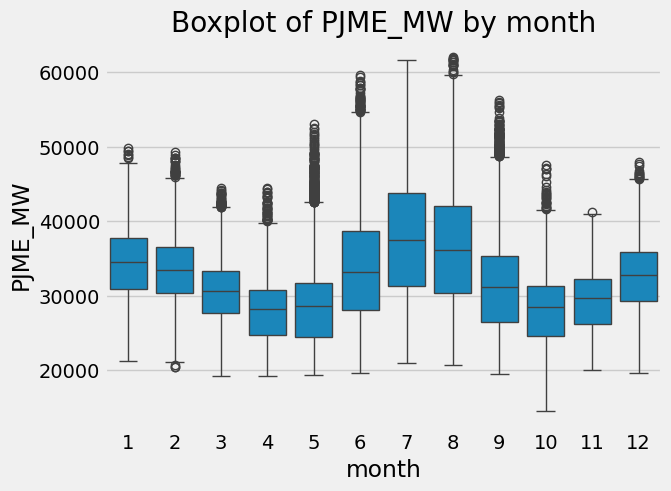

In [8]:
fig, ax = plt.subplots()
sns.boxplot(data = df, x = 'month', y = 'PJME_MW', ax = ax)
ax.set(title = 'Boxplot of PJME_MW by month')
plt.show()

Create our Model

In [9]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year','dayofyear']
TARGET = 'PJME_MW'

X_train, X_test = train[FEATURES], test[FEATURES]
y_train, y_test = train[TARGET], test[TARGET]

In [10]:
# Não entendi muito bem essa parte
# rmse começa a diminuir até um certo ponto depois aumenta. tem a ver com overfitting
# uma boa estratégia é diminuir o learning rate para evitar overfitting
# verbose = 100 é para mostrar o progresso do treinamento a cada 100 iterações. a iteração onde para sinaliza o overfitting (qnd fica pior)
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50,learning_rate = 0.01)
reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],

        verbose = 100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.26089


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Feature Importance

In [11]:
# index se refere às linhas
fi = pd.DataFrame(reg.feature_importances_,
                  index = reg.feature_names_in_,
                  columns = ['importance'])

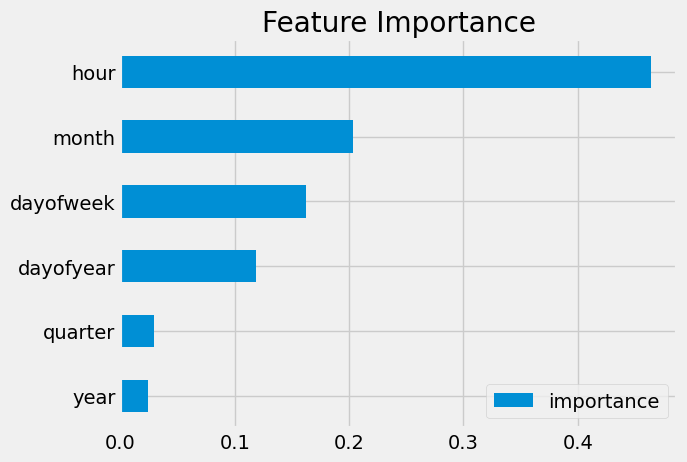

In [12]:
fi.sort_values('importance', ascending = True).plot(kind = 'barh', title = 'Feature Importance')
plt.show()

In [13]:
test['MW_Prediction'] = reg.predict(X_test)
df = df.merge(test[['MW_Prediction']], how = 'left', left_index = True, right_index = True)

In [14]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,MW_Prediction
Datetime,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,NaN
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,NaN
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,NaN
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,NaN
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,NaN


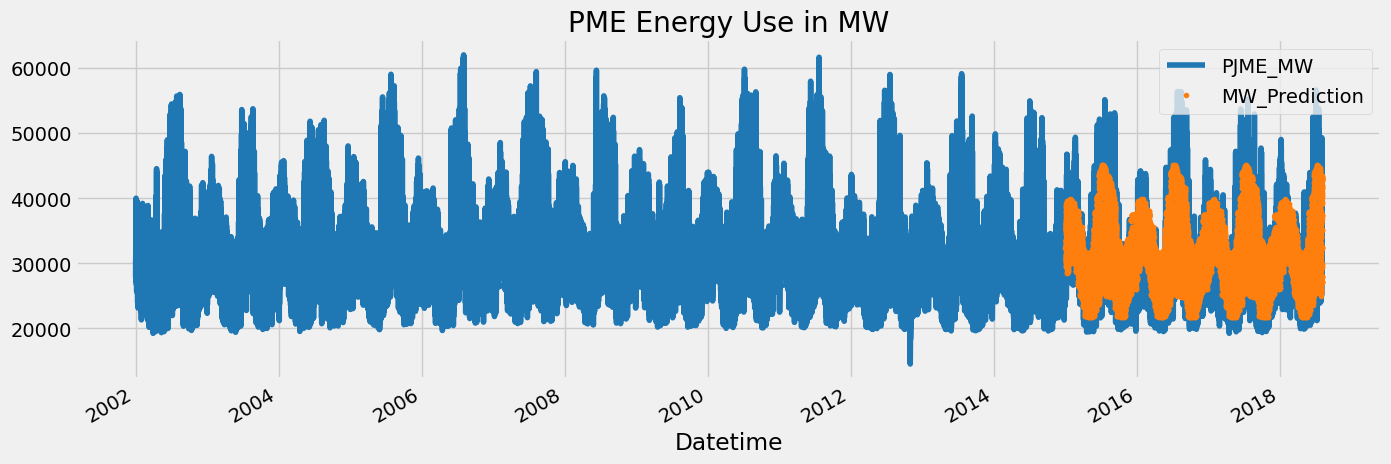

In [15]:
ax = df[['PJME_MW']].plot(figsize = (15,5), color = color_pal[0])
df[['MW_Prediction']].plot(ax = ax, color = color_pal[1], style = '.')
ax.set(title = 'PME Energy Use in MW')
plt.show()

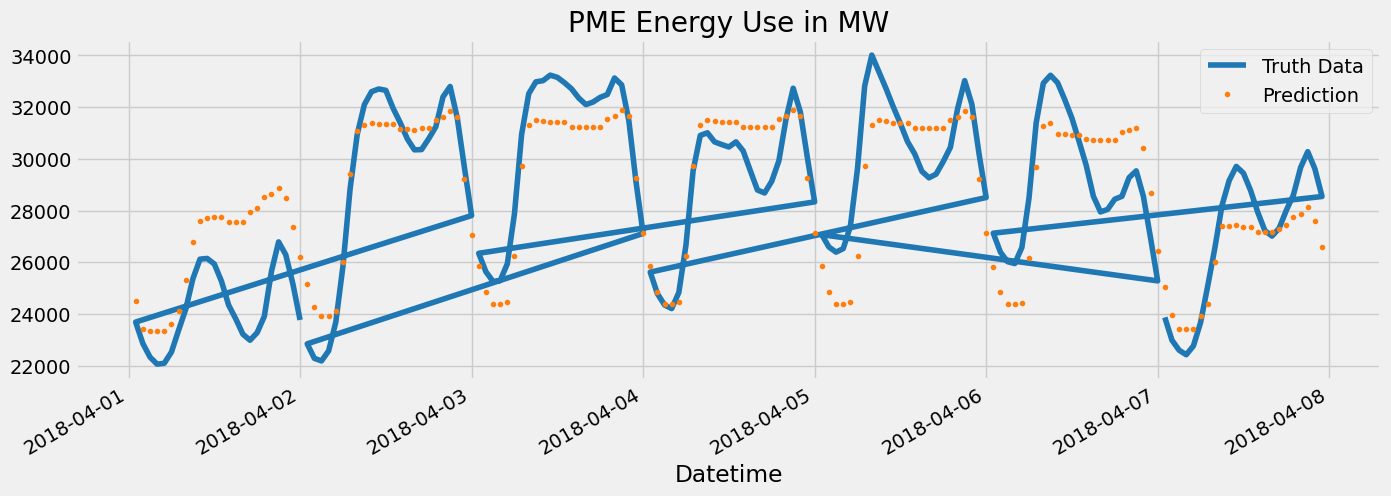

In [16]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018') ]['PJME_MW'].plot(figsize = (15,5), color = color_pal[0])
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018') ]['MW_Prediction'].plot(figsize = (15,5), color = color_pal[1], style = '.')
ax.set(title = 'PME Energy Use in MW')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [17]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['MW_Prediction']))
score

3741.030178837441

In [18]:
test['error'] = abs(test['PJME_MW'] - test['MW_Prediction'])
test['date'] = test.index.date

#worst predictions

test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
Name: error, dtype: float64

In [19]:
# best predictions
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2016-12-30    395.436442
2017-10-24    413.885824
2016-10-27    440.053141
2016-04-04    440.223877
2017-05-02    453.738688
Name: error, dtype: float64

Next steps

- More robust cross validation
- Add more features (weather, holidays, etc). In our case we can see dates realted to school, office, etc.